# PA005: High Value Customer Identification

## <font color='red'> Ciclo 00 - Planejamento - Método IOT </font>

## <font color='red'> Ciclo 01 - Métricas de Validação de Clusters </font>

1. Feature Engineering
    - Recência
    - Frequência
    - Monetização
    
    
2. Métricas de validação de Clustering
    - WSS ( Within-Cluster Sum of Square )  
    - SS ( Silhouette Score )
    
    
3. Cluster Analysis
    - Plot 3D
    - Cluster Profile

## <font color='red'> Ciclo 02 - Análise de Silhouette </font>

1. Feature Engineering
    - Average Ticket
    
    
2. Análise de Silhouette
    - Silhouette Analysis  
    
    
3. Cluster Visualization
    - UMAP
    
    
4. Cluster Análise de Perfil
    - Descrição dos centróides dos cluster

## <font color='red'> Ciclo 03 - Statistical Descriptive </font>

1. Análise Descritiva
    - Atributos numéricos
    - Atributos categóricos
    
    
2. Feature Engineering
    - Average Recency
    - Number of Returns
    
    
2. Data preparation
    - Standard Scaler

# 0.0. Planejamento da Solução ( IOT )

## Input - Entrada

### O problema de negócio

1. Selecionar os mais valiosos clientes para formar o programa de fidelidade **"INSIDERS"**
2. Conjunto de dados com as vendas de produtos durante 1 ano ( Nov 2015 to Dec 2017 )

## Output - Saída

1. A indicação de pessoas para fazer parte do programa de fidelidade **"INSIDERS"**.
2. Relatório com as respostas para as seguintes perguntas:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks - Processo

1. **Quem são as pessoas elegíveis para participar do programa de Insiders ?**
    - O que é ser elegível ? O que é um cliente "valioso" para a empresa ?
        - Faturamento:
            - Alto Ticket Médio
            - Alto LTV
            - Baixa Recência ou Alta Frequência ( tempo entre as compras )
            - Alto Basket Size ( quantidade média de produtos comprados )
            - Baixa probabilidade de Churn
            - Previsão alta de LTV
            - Alta propensão de compra

        - Custo:
            - Baixo número de devoluções

        - Experiência:  
            - Média alta de avaliações
            
            
2. **Quantos clientes farão parte do grupo?**
    - Número de clientes
    - % em relação ao total de clients
    
    
3. **Quais as principais características desses clientes ?**
    - Escrever os principais atributos dos clientes
        - Idade
        - País
        - Salário
        
    - Escrever os principais comportamentos de compra dos clients ( métricas de negócio )
        - Vide acima
    
    
4. **Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?**
    - Calcular o faturamento total da empresa durante o ano.
    - Calcular o faturamento (%) apenas do cluster Insiders.
    
    
5. **Qual a expectativa de faturamento desse grupo para os próximos meses ?**
    - Cálculo do LTV do grupo Insiders
    - Séries Temporais ( ARMA, ARIMA, HoltWinter, etc )
    

6. **Quais as condições para uma pessoa ser elegível ao Insiders ?**
    - Qual o período de avaliação ?
    - O "desempenho" do cliente está próximo da média do cluster Insiders. 
    
    
7. **Quais as condições para uma pessoa ser removida do Insiders ?**
    - O "desempenho" do cliente não está mais próximo da média do cluster Insiders. 
    
    
8. **Qual a garantia que o programa Insiders é melhor que o restante da base ?**
    - Teste de Hipóteses
    - Teste A/B
    
    
9. **Quais ações o time de marketing pode realizar para aumentar o faturamento?**
    - Descontos
    - Preferências de escolha
    - Produtos exclusivos

# 0.0. Imports

In [2]:
import numpy   as np
import pandas  as pd
import seaborn as sns

import umap.umap_ as umap

from IPython.display import HTML
from matplotlib import pyplot as plt

from pandas_profiling import ProfileReport

from sklearn import cluster       as c
from sklearn import metrics       as m
from sklearn import ensemble      as en
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn import manifold      as mn
from sklearn import mixture       as mx

from plotly import express as px

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1. Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Load dataset

In [4]:
# load data
df_raw = pd.read_csv( '../data/raw/Ecommerce.csv' )

# drop extra column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1 )

# <font color='red'> 1.0. Descrição dos dados </font>

In [5]:
df1 = df_raw.copy()

## 1.1. Rename columuns

In [6]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data dimensions

In [7]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 541909
Number of cols: 8


## 1.3. Data types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [10]:
# Precisamos resolver o problema do NA

In [11]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [12]:
# create reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup ), 1)

# merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left' )

# coalesce 
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

# drop extra columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )

In [13]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change dtypes

In [14]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( int )
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [15]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7. Descriptive Statistics

In [16]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Attributs

In [17]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### <font color='red'> 1.7.1.1. Numerical Attributs - Investigating </font>

1. Quantity negativa ( pode ser devolução )


2. Preço unitário igual a zero ( pode ser promoção? )

### 1.7.2. Categorical Attributs

#### Invoice No

In [18]:
# problema: Temos invoice com letras e numeros
#df1['invoice_no'].astype( int )

# identficacao: 
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]
df_letter_invoices.head()

print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices: 9291
Total number of negative quantity: 9288


#### Stock Code

In [19]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

# Acão:
## 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description

In [20]:
df1.head()

# Acão: Delete description

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


#### Country

In [21]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [22]:
df1['country'].value_counts( normalize=True ).head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

In [23]:
df1[['customer_id', 'country']].drop_duplicates().groupby( 'country' ).count().reset_index().sort_values( 'customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# <font color='red'> 2.0. Filtragem de Variáveis </font>

In [24]:
df2 = df1.copy()

In [25]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

In [26]:
# === Numerical attributes ====
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

# description
df2 = df2.drop( columns='description', axis=1 )

# map -  
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

# <font color='red'> 3.0. Feature Engineering </font>

In [27]:
# Feature Ideas:
## Moving Average - 7d, 14d, 30d
## Quantidade de Compras por mês, antes do dia 15 e depois do dia 15
## Average Financial
## Basket Size * Price - Quantidade de preços por cesta

########
###
###
#######

In [28]:
df3 = df2.copy()

## 3.1. Feature Creation

In [31]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates( ignore_index=True )

### 3.1.1. Gross Revenue

In [32]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency - Day from last purchase

In [33]:
# Recency - Last day purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3. Quantity of purchased 

In [34]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
                                                             .groupby( 'customer_id' )
                                                             .count()
                                                             .reset_index()
                                                             .rename( columns={'invoice_no': 'qtde_invoices'}) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

### 3.1.4. Quantity total of items purchased 

In [35]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].groupby( 'customer_id' ).sum()
                                                           .reset_index()
                                                           .rename( columns={'quantity': 'qtde_items'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
dtype: int64

### 3.1.4. Quantity of products purchased 

In [36]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'qtde_products'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
dtype: int64

### 3.1.5. Average Ticket Value 

In [37]:
# Avg Ticket
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
dtype: int64

### 3.1.6. Average Recency Days 

In [38]:
# Average recency days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=['False', 'False'] )
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

# average recency 
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### 3.1.7. Frequency Purchase 

In [39]:
df_aux = ( df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

### 3.1.8. Number of Returns 

In [40]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

### 3.1.9. Basket Size - Quantidade de Items por Cesta ( Quantity )

- Invoice No = Compra = purchase
- Stock Code = Produto = Product
- Quantity = Item = Item

In [41]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                  n_products=( 'quantity', 'sum' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

### 3.2.0. Unique Basket Size - Quantidade de produtos distintos por compra 

In [42]:
# Trazer uma explicação mais clara sobre como calcular essa features

In [43]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                   n_products=( 'stock_code', 'nunique' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_items                  91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

In [44]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.500000,17.000000,40.0,50.970588,0.617647
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,27.250000,0.028302,35.0,154.444444,11.666667
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,23.187500,0.040323,50.0,335.200000,7.600000
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.017921,0.0,87.800000,4.800000
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,8.600000,0.073171,22.0,26.666667,0.333333


# <font color='red'> 4.0. EDA ( Exploratory Data Analysis ) </font>

In [45]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1. Univariate Analysis

**Metricas para olharmos**
1. Clusters Coesos - Separados
2. Métricas
    - Min, Máximo, Range ( Dispersão )
    - Média e Mediana
    - Desvio Padrão e Variância.
    - Coeficiente de Variação ( CV )
    - Distribuição

**Investigar/Remover**

1. Gross Revenue - ok

In [46]:
#profile = ProfileReport( df4 )
#profile.to_file( 'output_v3.html' )

### 4.1.1. Gross Revenue

In [47]:
df4.sort_values( 'gross_revenue', ascending=False ).head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,0.203390,288.0,2733.944444,9.708333
492,18102,259657.30,0.0,60.0,64124.0,431.0,602.453132,14.680000,0.163043,0.0,1068.733333,2.500000
433,17450,194550.79,8.0,46.0,69993.0,337.0,577.302047,12.821429,0.127778,952.0,1521.586957,2.695652
66,14911,140450.72,1.0,199.0,80263.0,5673.0,24.757751,2.601399,0.533512,3332.0,403.331658,8.974874
1150,12415,124564.53,24.0,20.0,77373.0,713.0,174.704811,20.866667,0.063694,427.0,3868.650000,22.150000


In [48]:
df3[df3['customer_id'] == 14646].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
37952,539491,21981,12,2016-12-18,0.29,Netherlands,14646
37953,539491,21986,12,2016-12-18,0.29,Netherlands,14646
37954,539491,22720,2,2016-12-18,4.95,Netherlands,14646
37955,539491,21931,1,2016-12-18,1.95,Netherlands,14646
37956,539491,22613,2,2016-12-18,0.85,Netherlands,14646


### 4.1.2. Qtde Items

In [49]:
df4[df4['qtde_items'] == 196844]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,0.20339,288.0,2733.944444,9.708333


### 4.1.3. Qtde Products

In [50]:
#df4[df4['qtde_products'] == 7838]
df3[df3['customer_id'] == 17841].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
1441,C536543,22632,-1,2016-11-29,2.10,United Kingdom,17841
1442,C536543,22355,-2,2016-11-29,0.85,United Kingdom,17841
2037,536557,21495,25,2016-11-29,0.42,United Kingdom,17841
2038,536557,46000R,2,2016-11-29,1.45,United Kingdom,17841
2039,536557,46000S,1,2016-11-29,1.45,United Kingdom,17841


### 4.1.3. Avg Ticket

In [51]:
#df4[df4['avg_ticket'] == 56157.5]
df3[df3['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id


### 4.1.4. Frequency

In [52]:
#df4[df4['frequency'] == 17]
df3[df3['customer_id'] == 17850]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850
5,536365,22752,2,2016-11-29,7.65,United Kingdom,17850
6,536365,21730,6,2016-11-29,4.25,United Kingdom,17850
7,536366,22633,6,2016-11-29,1.85,United Kingdom,17850
8,536366,22632,6,2016-11-29,1.85,United Kingdom,17850
47,536372,22632,6,2016-11-29,1.85,United Kingdom,17850


### 4.1.5. Average Basket Size

In [53]:
df4[df4['avg_basket_size'] == 40498.5]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size


## 4.2. Bivariate Analysis

In [54]:
cols = ['customer_id']
df42 = df4.drop( cols, axis=1 )

<Figure size 1800x864 with 0 Axes>

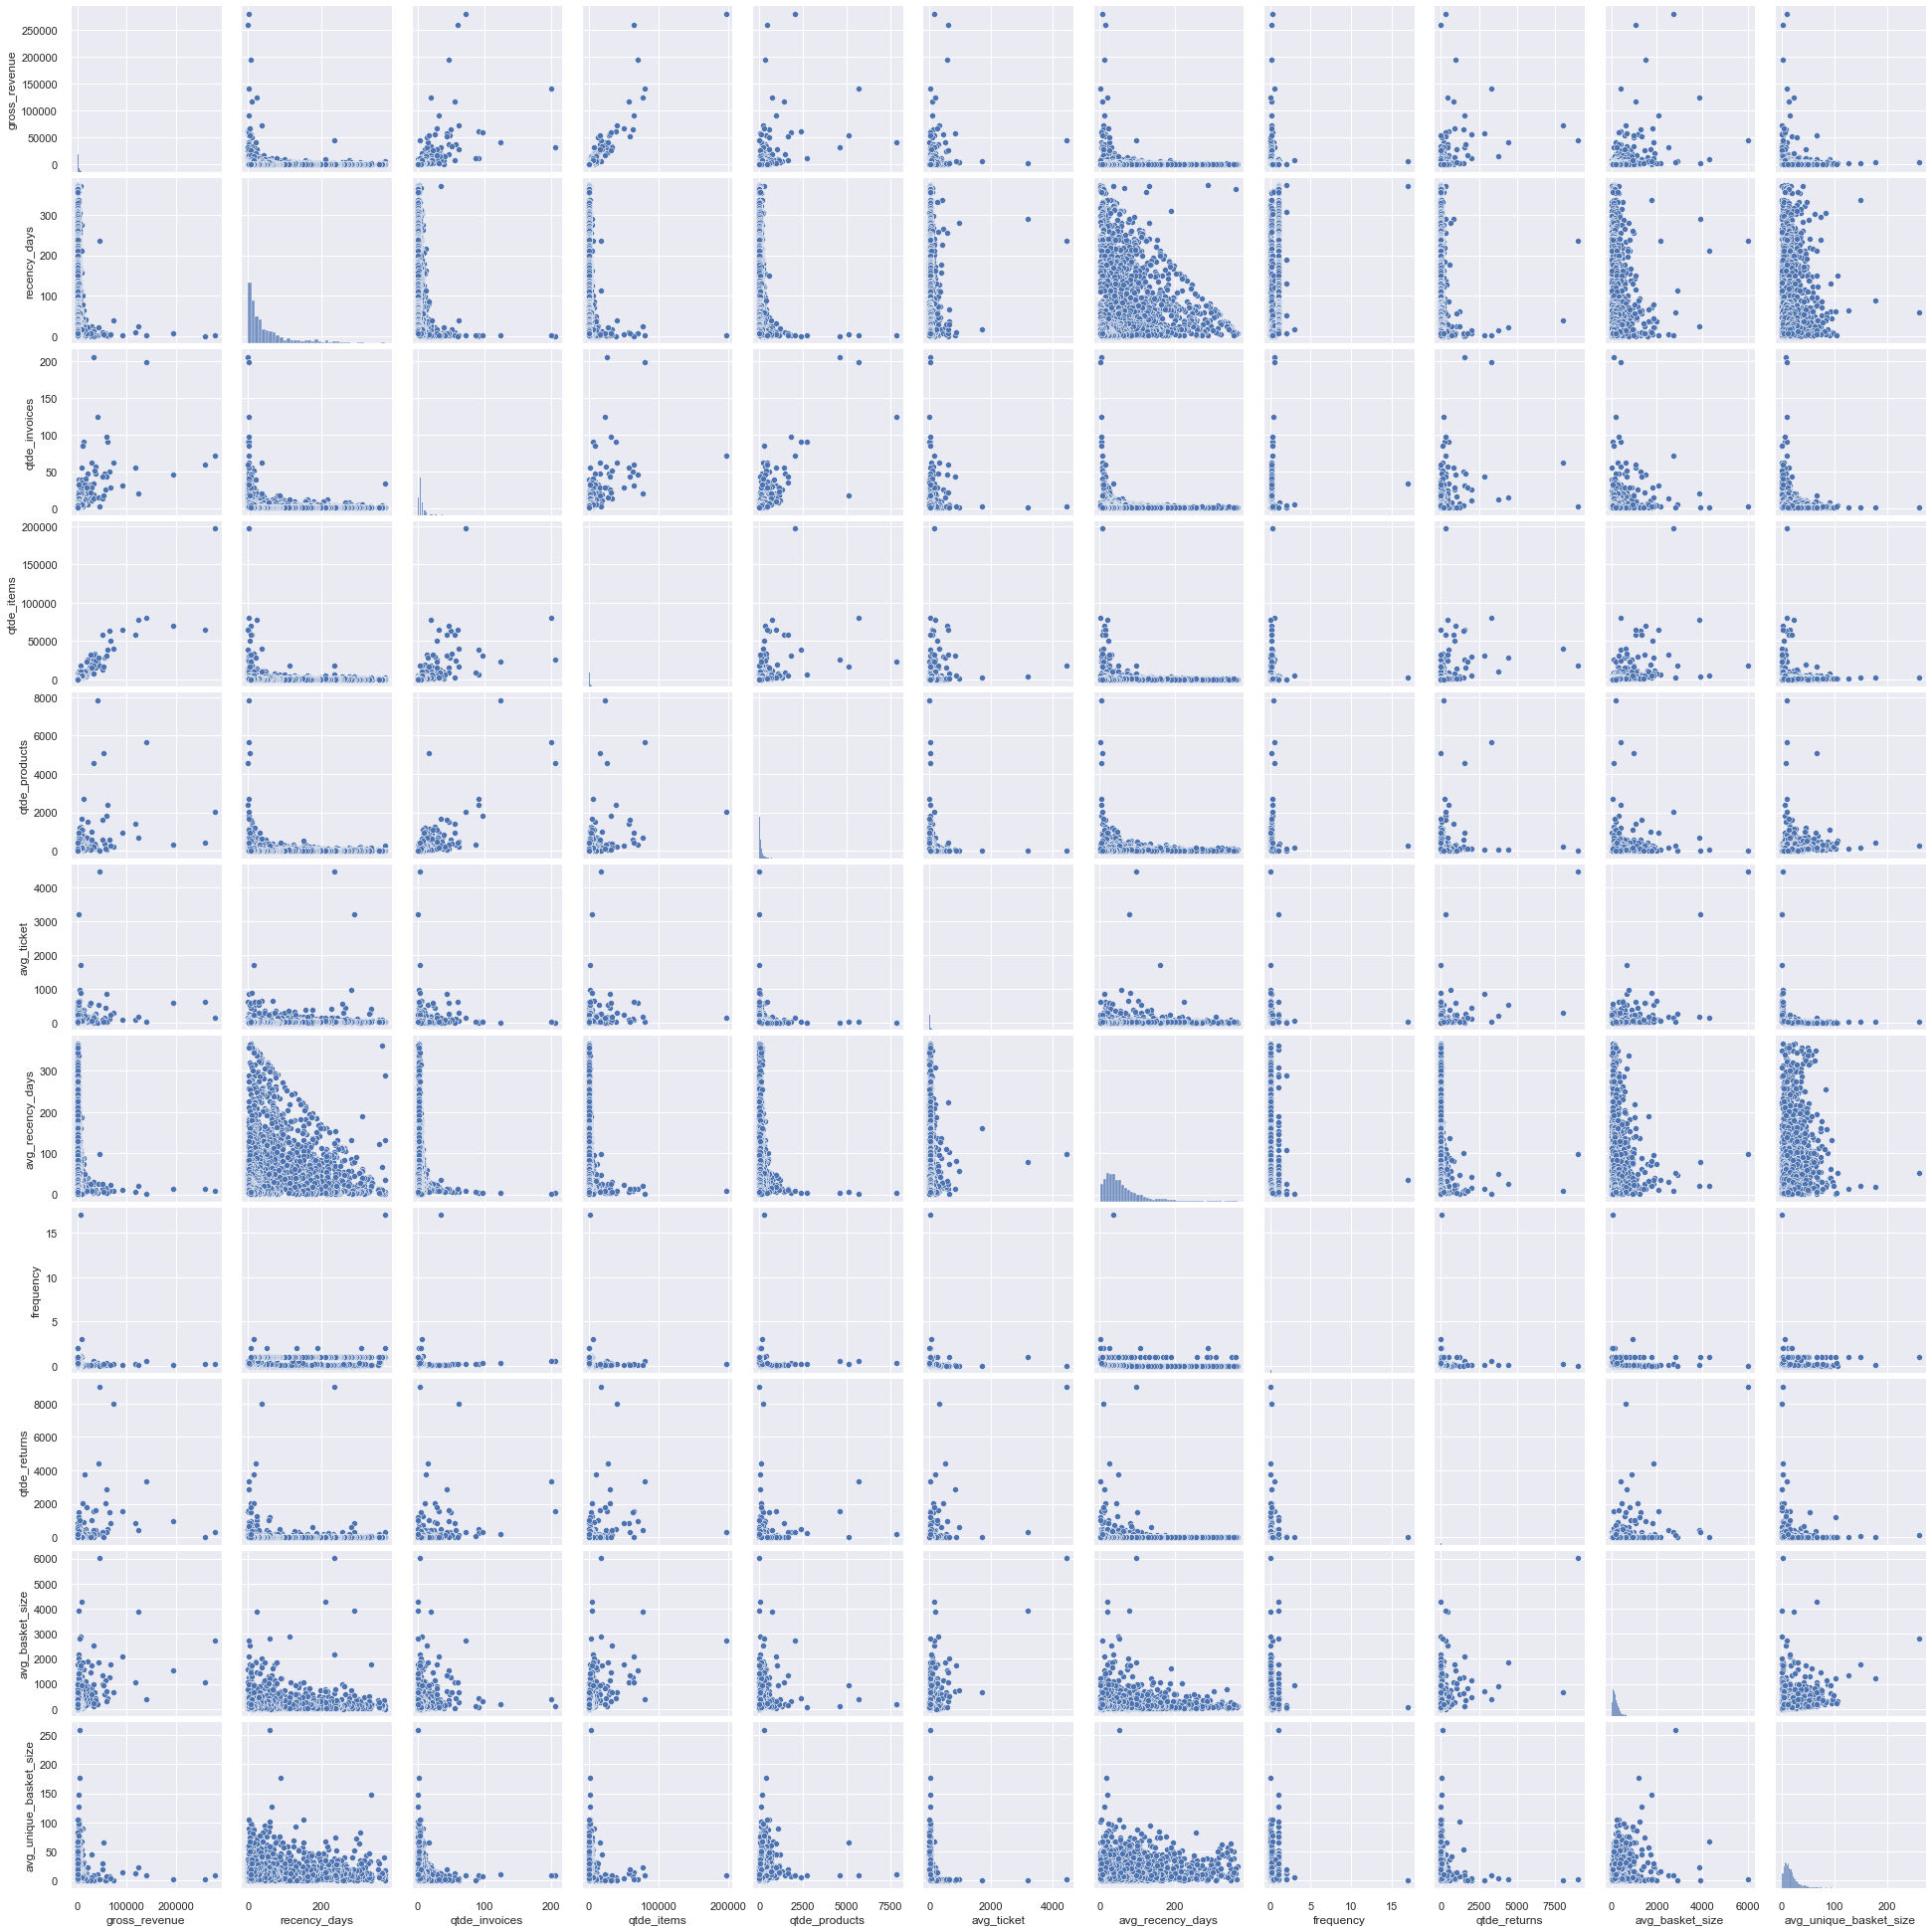

In [55]:
plt.figure( figsize=(25, 12) )
sns.pairplot( df42 )

**Notes**
1. Frequency has low variance
2. Avg Ticket has low variance

## 4.3. Estudo do Espaço

In [56]:
df43 = df4.drop( columns=['customer_id'], axis=1 ).copy()

In [57]:
mm = pp.MinMaxScaler()
# 

df43['gross_revenue'] = mm.fit_transform( df43[['gross_revenue']] )
df43['recency_days']           = mm.fit_transform( df43[['recency_days']] )
df43['qtde_invoices']          = mm.fit_transform( df43[['qtde_invoices']])
df43['qtde_items']             = mm.fit_transform( df43[['qtde_items']])
df43['qtde_products']          = mm.fit_transform( df43[['qtde_products']])
df43['avg_ticket']             = mm.fit_transform( df43[['avg_ticket']])
df43['avg_recency_days']       = mm.fit_transform( df43[['avg_recency_days']])
df43['frequency']              = mm.fit_transform( df43[['frequency']])
df43['qtde_returns']           = mm.fit_transform( df43[['qtde_returns']])
df43['avg_basket_size']        = mm.fit_transform( df43[['avg_basket_size']])
df43['avg_unique_basket_size'] = mm.fit_transform( df43[['avg_unique_basket_size']] )


X = df43.copy()

In [59]:
X.shape

(2968, 11)

### 4.3.1. PCA

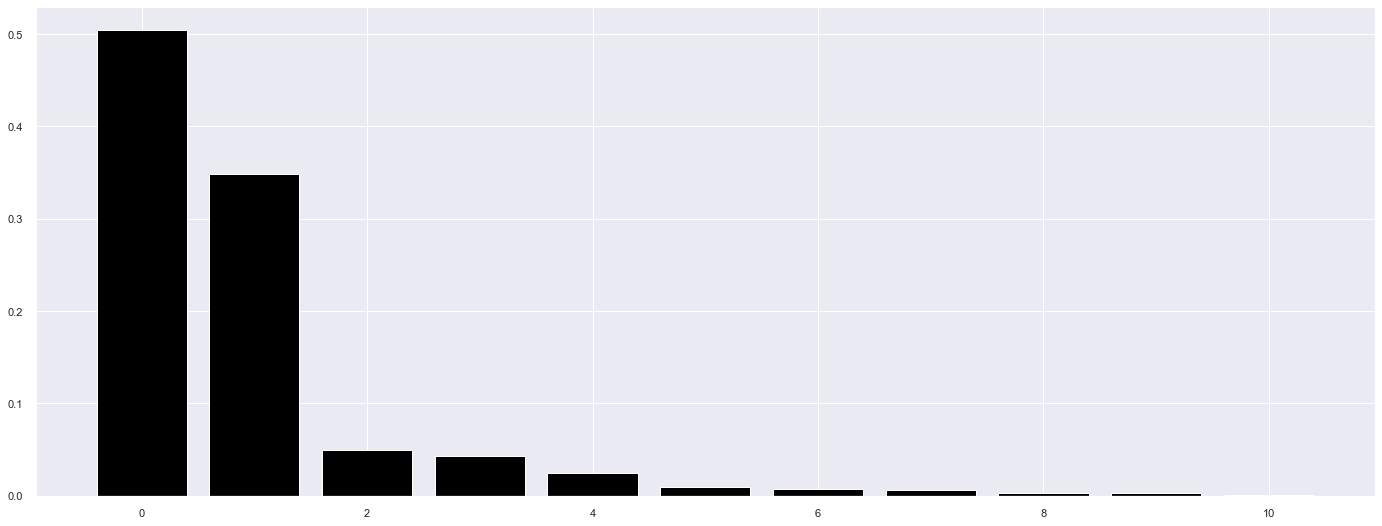

In [58]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )

<AxesSubplot:xlabel='0', ylabel='1'>

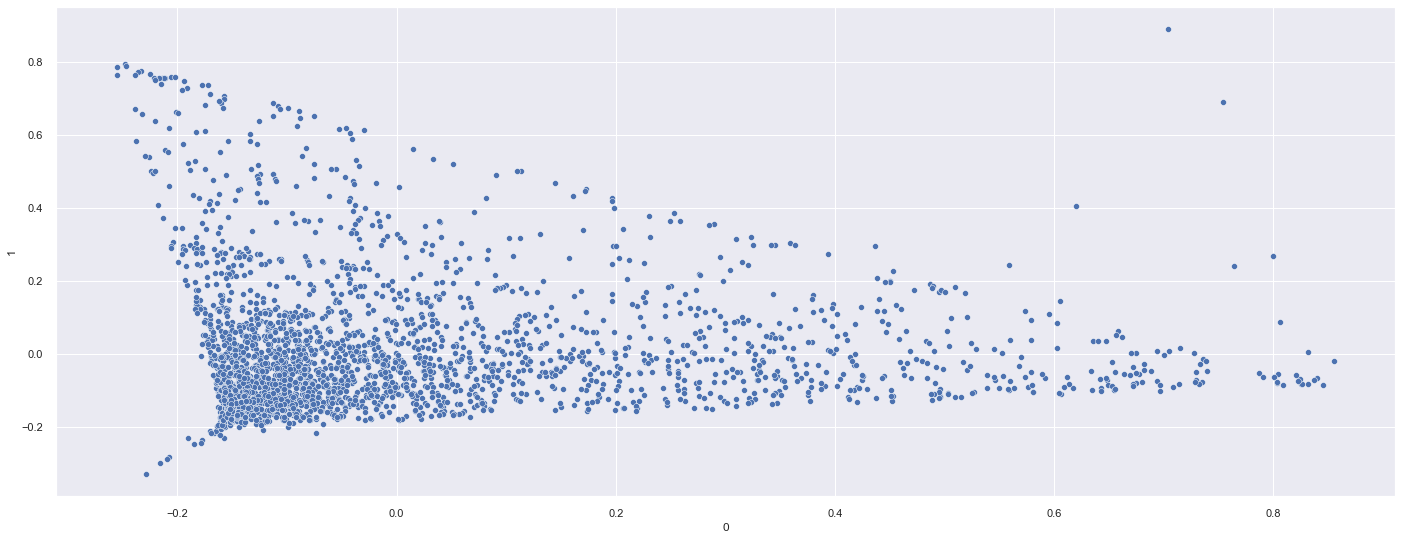

In [60]:
sns.scatterplot( x=0, y=1, data=df_pca )

### 4.3.2. UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

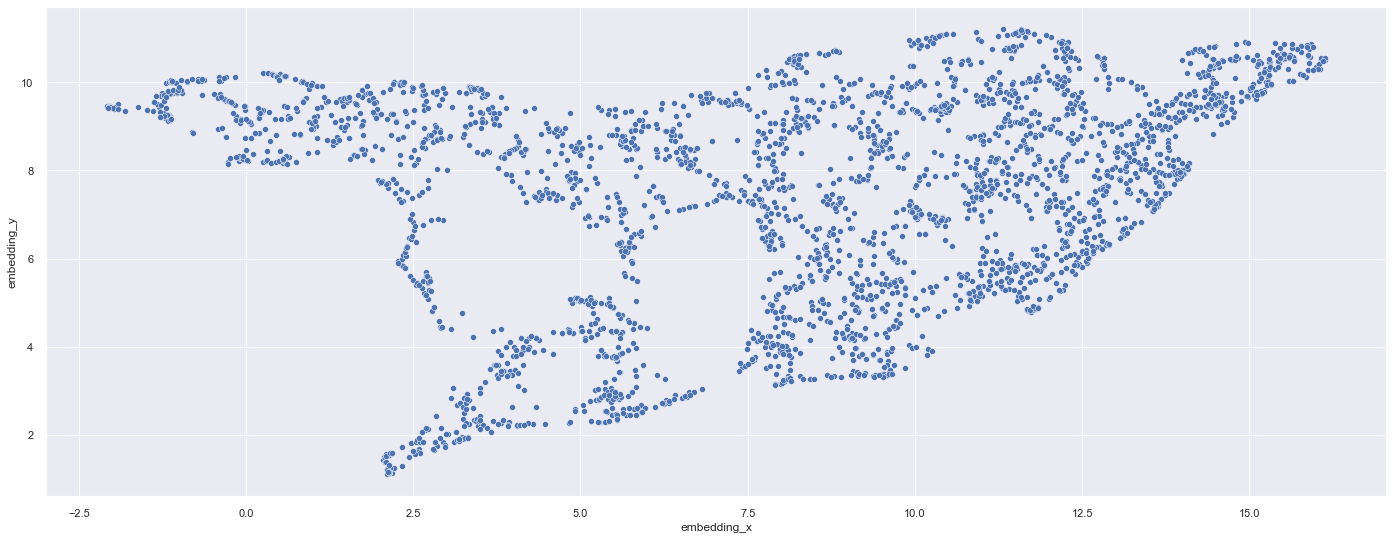

In [61]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_pca )

### 4.3.2. t-SNE

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

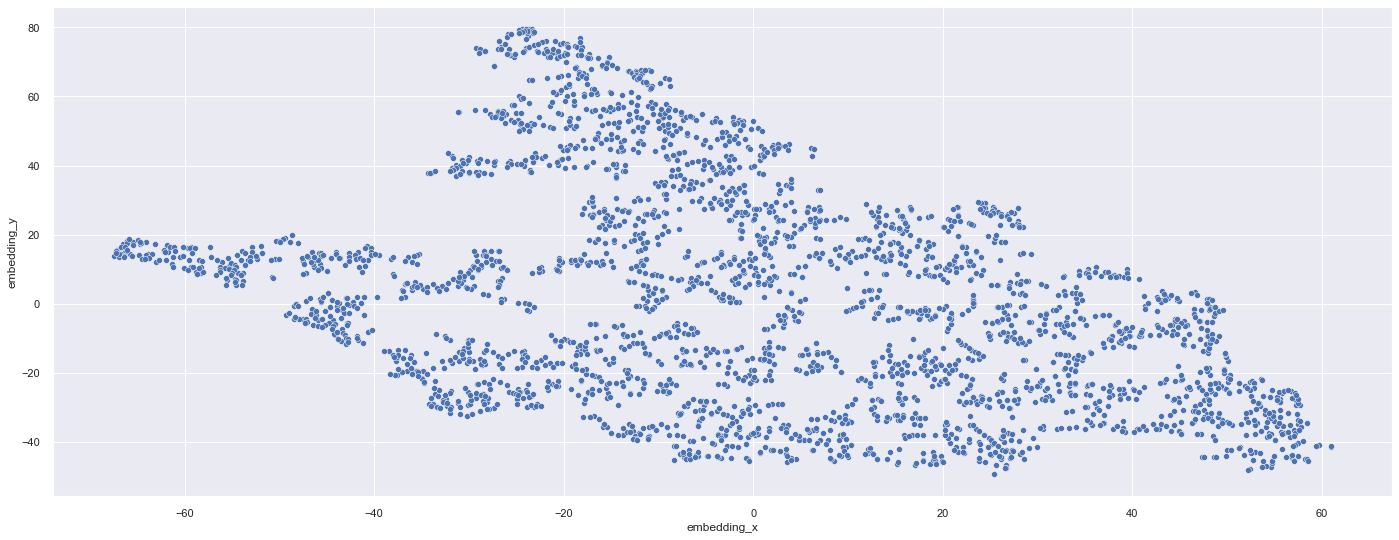

In [62]:
reducer = mn.TSNE( n_components=2, n_jobs=-1, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_pca )

### 4.3.3. Tree-Based Embedding

In [209]:
# training dataset
X = df4.drop( columns=['customer_id', 'gross_revenue'], axis=1 )
y = df4['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )

# Leaf 

# dataframe Leaf

RandomForestRegressor(random_state=42)

In [210]:
df_leaf = pd.DataFrame( rf_model.apply( X ) )

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

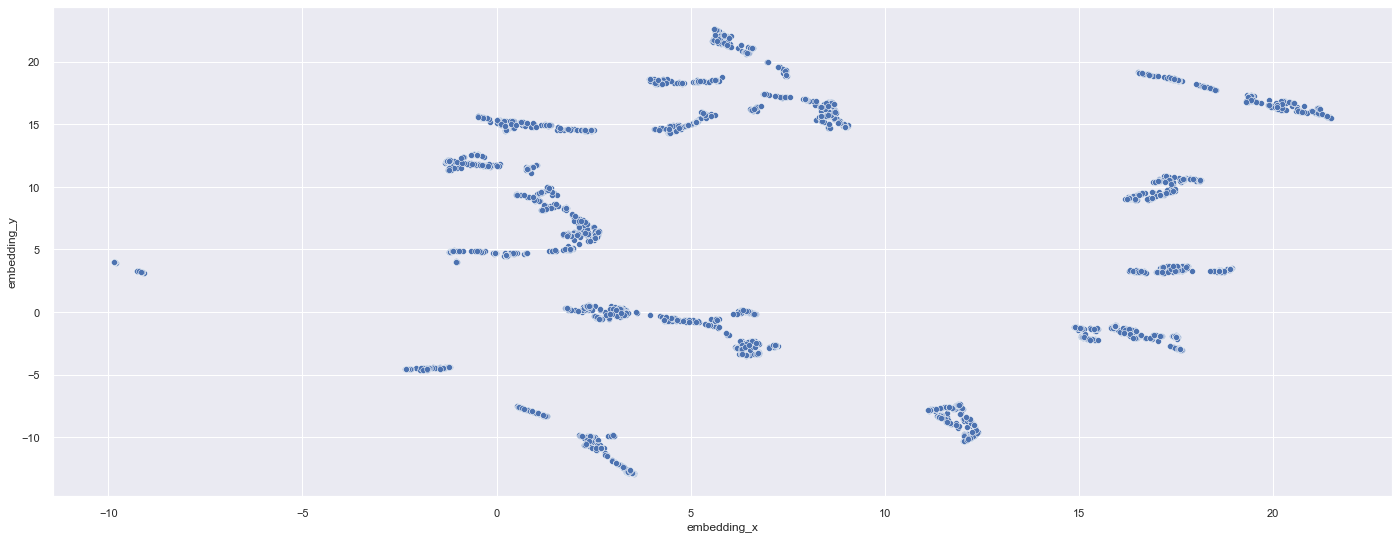

In [211]:
# Reduzer dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tree )

# <font color='red'> 5.0. Data Preparation </font>

In [212]:
#Padronização/Normalizção ( Standardization ) -> Premissa de que os dados vieram de um distribuição normal
#Rescala      ( Rescale )         -> Não Premissa de que os dados vieram de um distribuição normal

**Regra do Coração**
1. Distribuiçåo Normal e não possui Outlier -> Standard Scaler - Media e desvio padrao
2. Distribuiçåo Normal e possuí Outlier -> Robust Scaler - Quartis
3. Não distribuição normal -> Min Max Scaler

In [213]:
#**Testes de Normalidade**
#QQ Plot  - Quantile Quantile Plot ( Quatile teorica x Quantile real )
#KS Teste - Kolgomorov Smirnoff ( Teste de Hipótese ) Se p-value > 0.5 -> Distribuição Normal, p-value < 0.5 -> Não distribuição Normal
#
#**Detecção Outlier** 
#Box Plot -> Pontos são identificados como Outliers
#IRQ * 2.5 -> Acima desse valor ( Outlier )
#
#Z-Score > 3  -> Outilers
#Z-Score < -3 -> Outliers

In [214]:
#df5 = df4.copy()
df5 = df_tree.copy()

In [215]:
### Standard Scalaer
#ss = pp.StandardScaler()
#rs = pp.RobustScaler()
#        
#df5['gross_revenue'] = mm_gross_revenue.fit_transform( df5[['gross_revenue']] )
#
#df5['recency_days'] = mm.fit_transform( df5[['recency_days']] )
#
##df5['qtde_invoices'] = mm.fit_transform( df5[['qtde_invoices']] )
#
##df5['qtde_items'] = mm.fit_transform( df5[['qtde_items']] )
#
#df5['qtde_products'] = mm.fit_transform( df5[['qtde_products']] )
#
##df5['avg_ticket'] = mm.fit_transform( df5[['avg_ticket']] )
#
##df5['avg_recency_days'] = mm.fit_transform( df5[['avg_recency_days']] )
#
#df5['frequency'] = mm.fit_transform( df5[['frequency']] )
#
#df5['qtde_returns'] = mm.fit_transform( df5[['qtde_returns']] )
#
##df5['avg_basket_size'] = mm.fit_transform( df5[['avg_basket_size']] )
#
##df5['avg_unique_basket_size'] = mm.fit_transform( df5[['avg_unique_basket_size']] )

# <font color='red'> 6.0. Feature Selection </font>

In [216]:
#cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']

In [217]:
#df6 = df5[ cols_selected ].copy()
df6 = df_tree.copy()

# <font color='red'> 7.0. Hyperparameter Fine-Tunning </font>

In [218]:
#X = df6.drop( columns=['customer_id'] )
X = df_tree.copy()#df6.drop( columns=['customer_id'] )

In [219]:
X.head()

,embedding_x,embedding_y
0,18.806955,3.407070
1,15.046163,-1.921216
2,18.425873,17.854053
3,-1.210122,4.838439
4,7.417907,18.904572


In [234]:
#clusters = [2, 3, 4, 5, 6, 7, 8, 9]
clusters = np.arange( 2, 25, 1)
clusters

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

## 7.1. K-Means

In [238]:
from sklearn import metrics as m

In [239]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k )

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

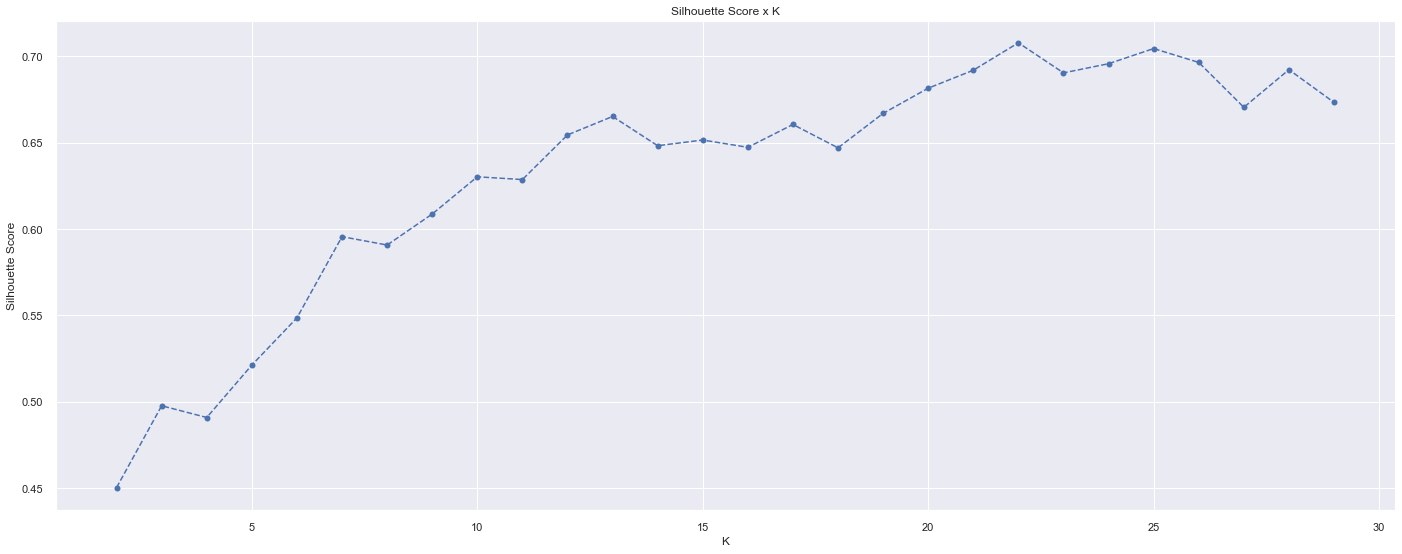

In [240]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

## 7.2. GMM

In [241]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components=k )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

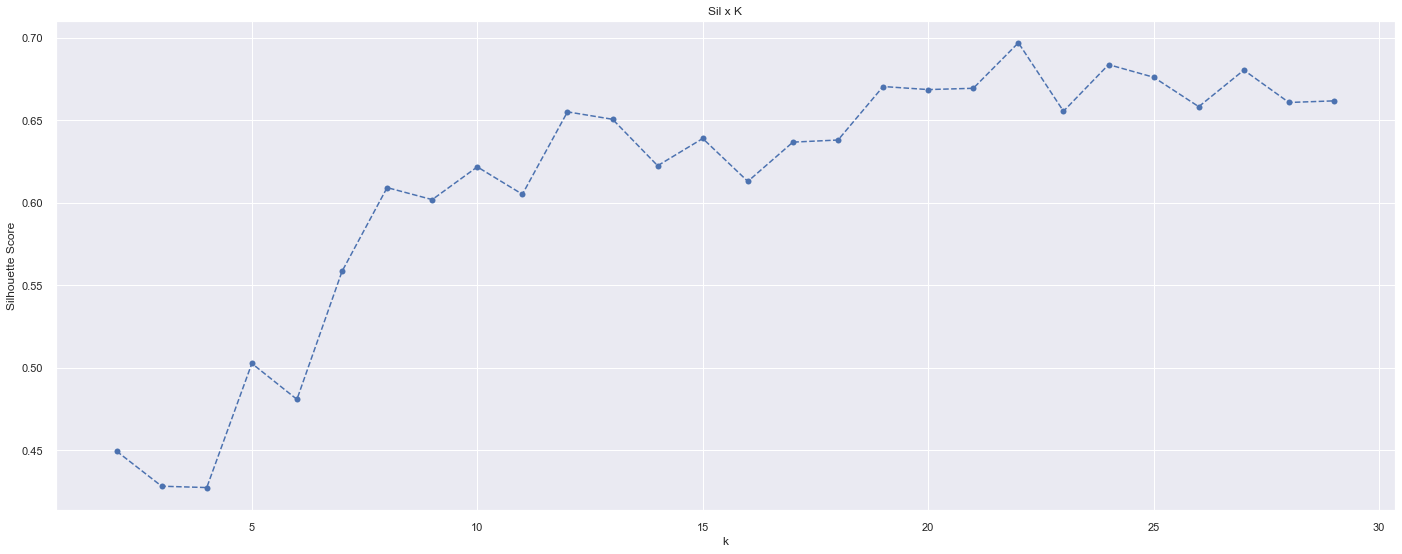

In [242]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score');
plt.title( 'Sil x K');

## 7.3. Hierarchical Clustering

In [243]:
from scipy.cluster import hierarchy as hc

In [244]:
# model definition and training
hc_model = hc.linkage( X, 'ward' )

In [245]:
#hc.dendrogram( 
#    hc_model, 
#    leaf_rotation=90,
#    leaf_font_size=8
#)
#
#plt.plot()

In [246]:
#hc.dendrogram( 
#    hc_model,
#    truncate_mode='lastp',
#    p=12,
#    leaf_rotation=90,
#    leaf_font_size=8,
#    show_contracted=True
#)
#
#plt.show()

### 7.3.1. HClustering Silhouette Score

In [247]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

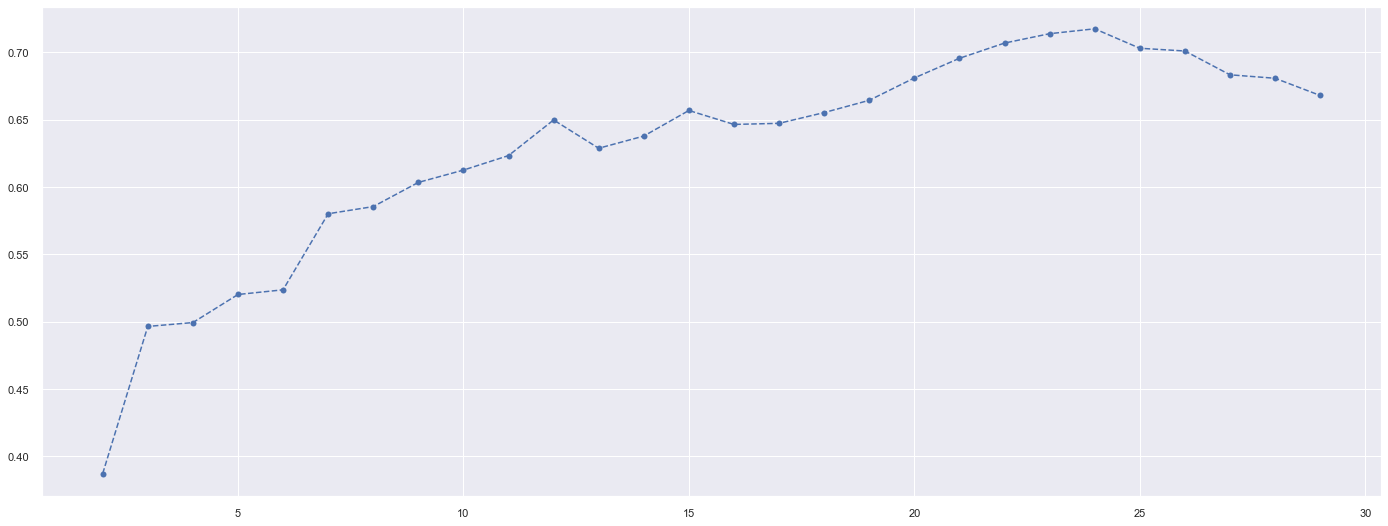

In [248]:
plt.plot( clusters,  hc_list, linestyle='--', marker='o', color='b' )

## 7.4. DBSCAN

In [251]:
eps=2.00
min_samples=20 

# model definition
dbscan_model = c.DBSCAN( eps=eps, min_samples=min_samples )

# mode training & predict 
labels = dbscan_model.fit_predict( X )

sil = m.silhouette_score( X, labels, metric='euclidean' )
print( 'Silhouette Score: {}'.format( sil ) )
print( 'Number of Clusters: {}'.format( len( unique( labels ) ) ) )
print( unique( labels ) )

Silhouette Score: 0.6572873592376709
Number of Clusters: 11
[ 0  1  2  3  4  5  6  7  8  9 10]


In [176]:
from sklearn.neighbors import NearestNeighbors

In [177]:
neighbors = NearestNeighbors( n_neighbors=min_samples ).fit( X )
distances, indices = neighbors.kneighbors( X )

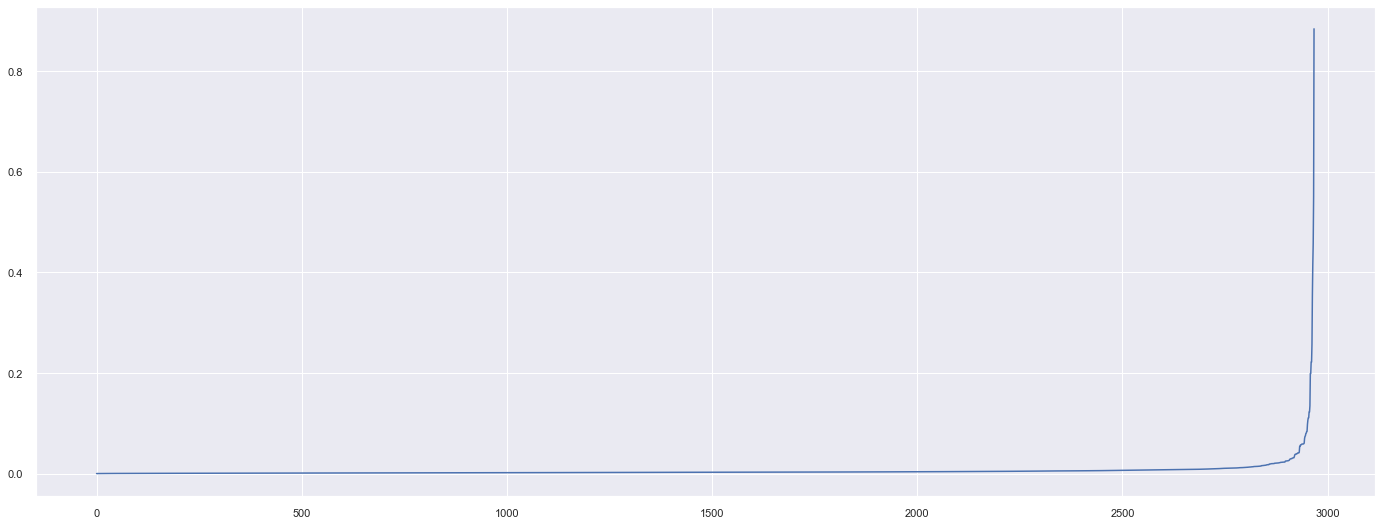

In [178]:
distances = np.sort( distances, axis=0 )
distances = distances[:,1]
plt.plot( distances )

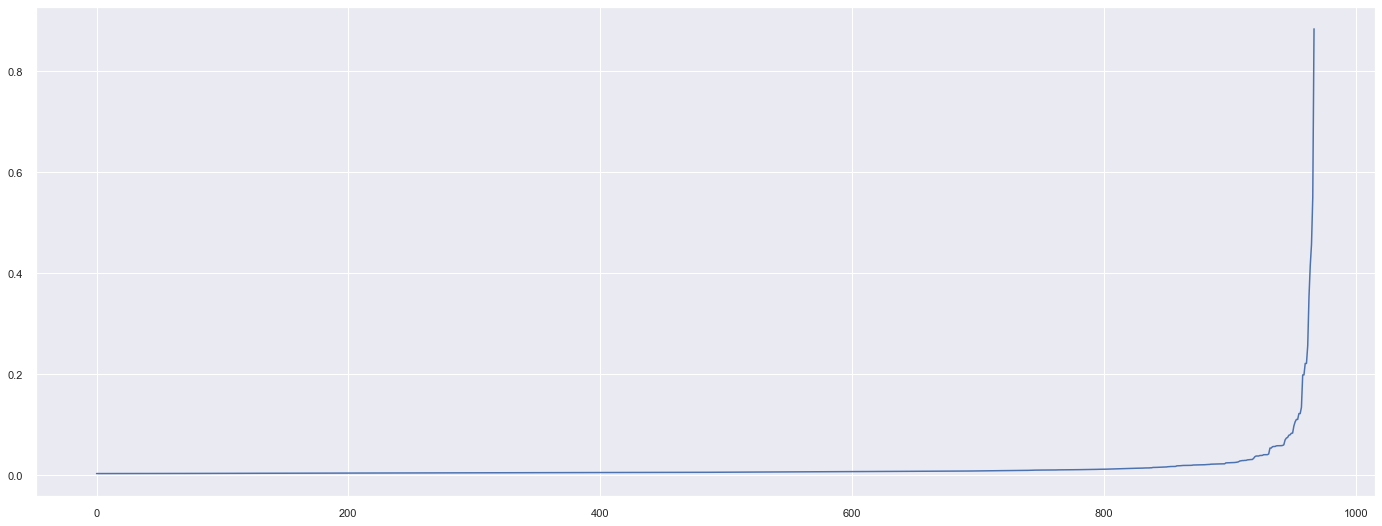

In [179]:
plt.plot( distances[2000:] )

In [180]:
dbscan_list = [ 0.622034, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

## 7.5. Results

In [252]:
# Model Name | k=2 | k=3 | k=4 | k=5 | ...
#  Kmeans      SS    SS    SS    SS
#  GMM         SS    SS    SS    SS
#  HC         SS     SS    SS    SS
#  DBSCAN     SS    SS    SS    SS

df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list}
     #'DBSCAN': dbscan_list}
).T

df_results.columns = clusters

In [253]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
KMeans,0.450201,0.497573,0.490774,0.521147,0.548483,0.595492,0.590653,0.608599,0.630169,0.628573,0.654408,0.665105,0.648173,0.651460,0.647240,0.660471,0.646932,0.666884,0.681475,0.691882,0.707766,0.690347,0.695661,0.704432,0.696403,0.670408,0.692198,0.673238
GMM,0.449450,0.428236,0.427412,0.502586,0.480835,0.558344,0.609092,0.601812,0.621639,0.605051,0.654966,0.650475,0.622344,0.638833,0.612846,0.636631,0.637906,0.670310,0.668461,0.669243,0.696793,0.655343,0.683578,0.675936,0.658110,0.680244,0.660647,0.661623
HC,0.387284,0.496557,0.499412,0.520270,0.523747,0.580235,0.585561,0.603507,0.612664,0.623428,0.649880,0.628875,0.637932,0.656930,0.646569,0.647388,0.655372,0.664487,0.681079,0.695682,0.706997,0.713957,0.717594,0.703142,0.701109,0.683432,0.680857,0.668082


In [186]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7
KMeans,0.722958,0.592730,0.562694,0.580862,0.546548,0.514707
GMM,0.042310,-0.016524,0.174489,-0.119071,-0.123871,-0.169081
HC,0.721382,0.570514,0.562887,0.496029,0.515360,0.515740
DBSCAN,0.622034,0.000000,0.000000,0.000000,0.000000,0.000000


In [94]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7
KMeans,0.507904,0.519431,0.385396,0.356885,0.373005,0.341061
GMM,-0.004519,0.012877,0.006964,-0.048131,-0.058627,-0.092325
HC,0.468911,0.498824,0.327713,0.316046,0.328641,0.325372
DBSCAN,0.622034,0.000000,0.000000,0.000000,0.000000,0.000000


## 7.1. Silhouette Analysis

 For K = 2. Silhouette Score: 0.7213816951267069
 For K = 3. Silhouette Score: 0.570514250543775
 For K = 4. Silhouette Score: 0.5628868025667392
 For K = 5. Silhouette Score: 0.496029498585056
 For K = 6. Silhouette Score: 0.5153598803895931
 For K = 7. Silhouette Score: 0.5157399754133227


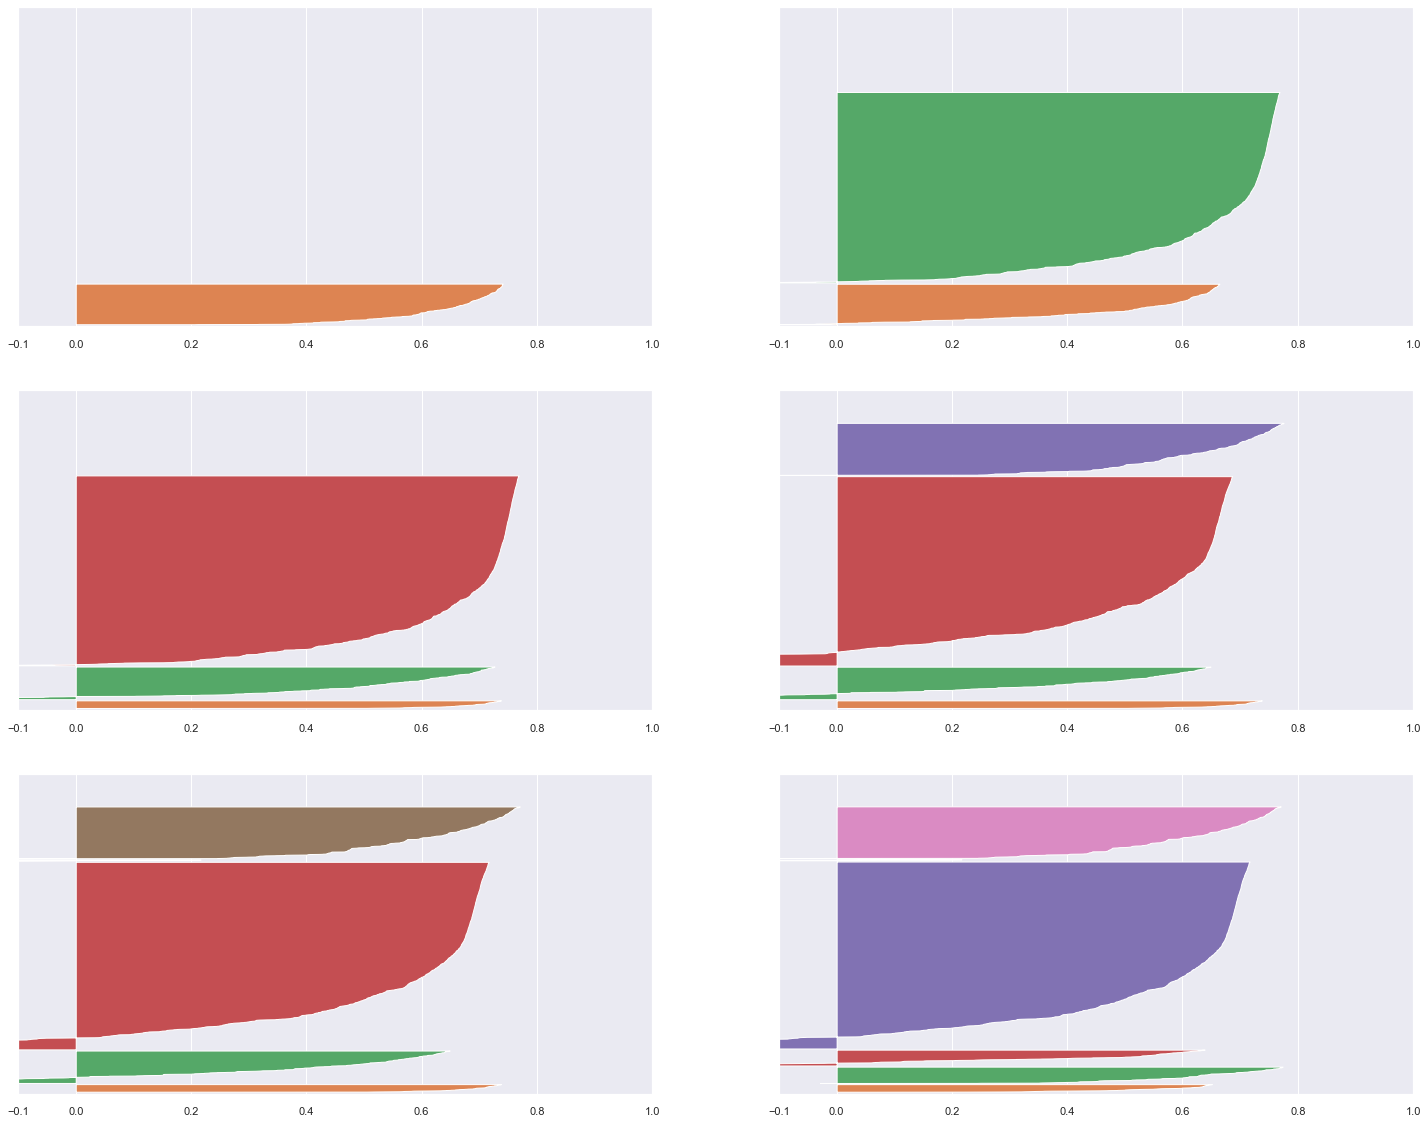

In [187]:
fig, ax = plt.subplots( 3, 2 )
fig.set_size_inches( 25, 20 )

for k in clusters:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [ -0.1, 1] )
    ax[q-1, mod].set_ylim( [ 0, len( X ) + ( k+1 )*10] )
    
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # performance
    ss = m.silhouette_score( X, labels, metric='euclidean' )
    print( ' For K = {}. Silhouette Score: {}'.format( k, ss ) )

    samples_silhouette_values = m.silhouette_samples( X, labels )

    y_lower = 10
    for i in range( k ):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap( 'Spectral' )
        color = cmap( i / k )

        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values  )
        
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# <font color='red'> 8.0. Model Training </font>

## 8.1. K-Means

In [293]:
## model definition
#k = 8
#kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300 )
#
## model training
#kmeans.fit( X )
#
## clustering
#labels = kmeans.labels_

In [300]:
k=9
# model definition
kmeans = mx.GaussianMixture( n_components=k )

# model training
kmeans.fit( X )

# model predict
labels = kmeans.predict( X )

### 8.2. Cluster Validation

In [301]:
## WSS ( Within-cluster sum of square)
print( 'WSS value: {}'.format( kmeans.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

AttributeError: 'GaussianMixture' object has no attribute 'inertia_'

# <font color='red'> 9.0. Cluster Analysis </font>

In [302]:
X.head()

,embedding_x,embedding_y
0,18.806955,3.407070
1,15.046163,-1.921216
2,18.425873,17.854053
3,-1.210122,4.838439
4,7.417907,18.904572


In [303]:
df9 = X.copy()
df9['cluster'] = labels

In [304]:
#df9 = df4.copy()
#df9['cluster'] = labels
df9.head()

,embedding_x,embedding_y,cluster
0,18.806955,3.407070,5
1,15.046163,-1.921216,5
2,18.425873,17.854053,2
3,-1.210122,4.838439,0
4,7.417907,18.904572,3


## 9.1. Visualization Inspection

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

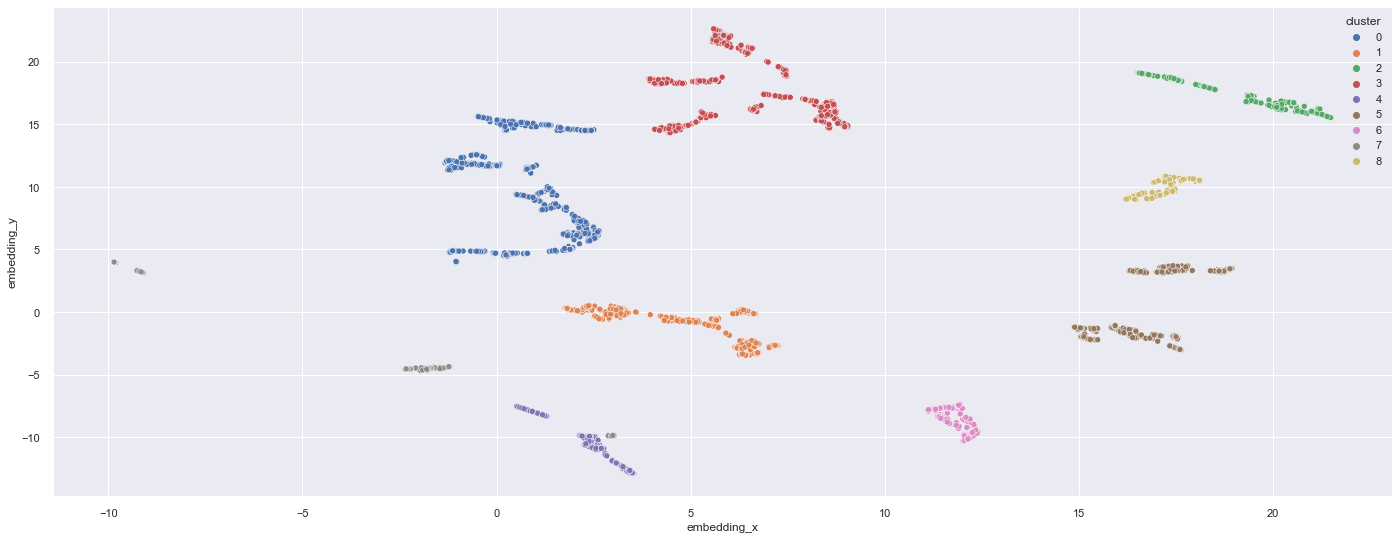

In [305]:
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep')

In [306]:
#visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick' )
#visualizer.fit( X )
#visualizer.finalize()

## 9.2. 2d plot

In [307]:
df_viz = df9.drop( columns='customer_id', axis=1 )
#sns.pairplot( df_viz, hue='cluster' )

KeyError: "['customer_id'] not found in axis"

## 9.3. UMAP


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

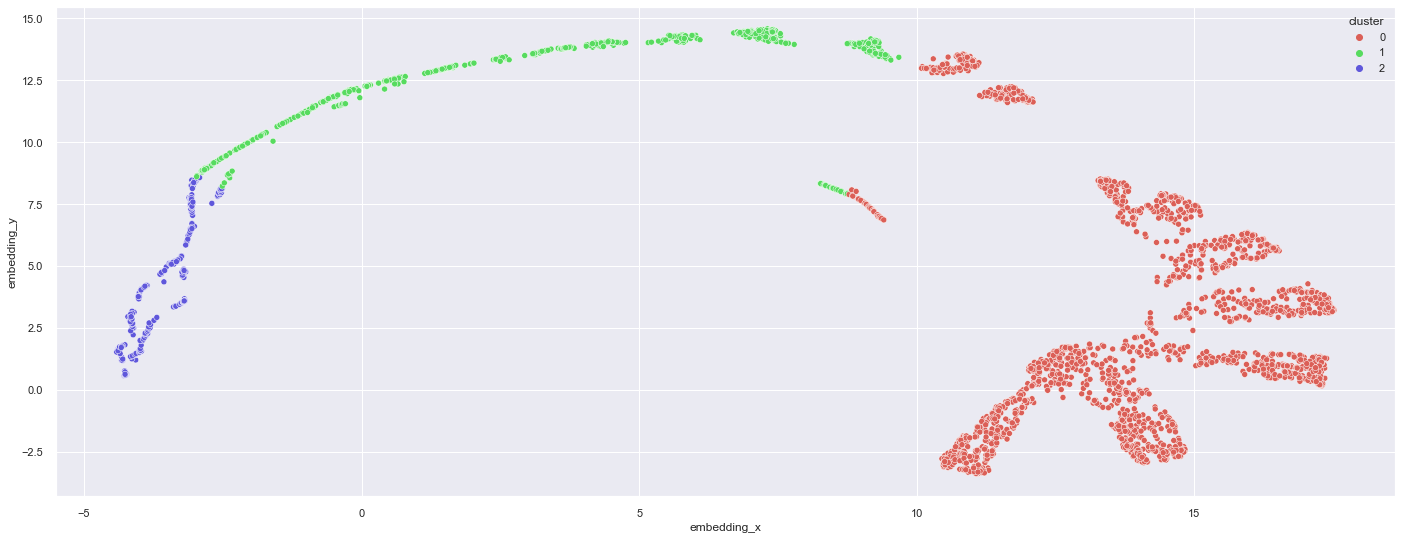

In [205]:
reducer = umap.UMAP( n_neighbors=90, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 hue='cluster', 
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data=df_viz )

## 9.2. Cluster Profile

In [206]:
df9.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size,cluster
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.500000,17.000000,40.0,50.970588,0.617647,2
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,27.250000,0.028302,35.0,154.444444,11.666667,0
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,23.187500,0.040323,50.0,335.200000,7.600000,0
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.017921,0.0,87.800000,4.800000,1
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,8.600000,0.073171,22.0,26.666667,0.333333,2


In [207]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_invoice_no = df9[['qtde_products', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

# Frequency
df_invoice_no = df9[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

# Returns
df_invoice_no = df9[['qtde_returns', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
0,0,1983,66.812668,3490.634095,21.168432,157.032779,0.063861,41.073122
1,1,652,21.967655,1205.066457,102.593558,62.000000,0.118220,9.656442
2,2,333,11.219677,860.759520,246.252252,37.672673,0.402817,47.462462


### Cluster 01:  ( Candidato à Insider )
    - Número de customers: 6 (0.14% do customers )
    - Recência em média: 7 dias
    - Compras em média: 89 compras
    - Receita em média: $182.182,00 dólares
        
### Cluster 02: 
    - Número de customers: 31 (0.71 do customers )
    - Recência em média: 14 dias
    - Compras em média: 53 compras
    - Receita em média: $40.543,52 dólares
        
### Cluster 03: 
    - Número de customers: 4.335 (99% do customers )
    - Recência em média: 92 dias
    - Compras em média: 5 compras
    - Receita em média: $1.372,57 dólares

# <font color='red'> 10.0. Deploy To Production </font>